### Detect toxic content to improve online conversations

Predict whether a question asked on Quora is sincere or not. An insincere question is defined as a question intended to make a statement rather than look for helpful answers. Some characteristics that can signify that a question is insincere:

Has a non-neutral tone
* Has an exaggerated tone to underscore a point about a group of people
* Is rhetorical and meant to imply a statement about a group of people

Is disparaging or inflammatory
* Suggests a discriminatory idea against a protected class of people, or seeks confirmation of a stereotype
* Makes disparaging attacks/insults against a specific person or group of people
* Based on an outlandish premise about a group of people
* Disparages against a characteristic that is not fixable and not measurable

Isn't grounded in reality
* Based on false information, or contains absurd assumptions

Uses sexual content for shock value, and not to seek genuine answers

### Code

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import fastai 
fastai.__version__

'1.0.39'

In [4]:
import fastai.utils
fastai.show_install()



```text
=== Software === 
python version  : 3.6.7
fastai version  : 1.0.34
torch version   : 1.0.0.dev20181024
nvidia driver   : 396.44
torch cuda ver  : 9.2.148
torch cuda is   : available
torch cudnn ver : 7104
torch cudnn is  : enabled

=== Hardware === 
nvidia gpus     : 1
torch available : 1
  - gpu0        : 7611MB | Tesla P4

=== Environment === 
platform        : Linux-4.9.0-8-amd64-x86_64-with-debian-9.5
distro          : #1 SMP Debian 4.9.110-3+deb9u6 (2018-10-08)
conda env       : Unknown
python          : /opt/anaconda3/bin/python
sys.path        : 
/opt/anaconda3/lib/python36.zip
/opt/anaconda3/lib/python3.6
/opt/anaconda3/lib/python3.6/lib-dynload
/opt/anaconda3/lib/python3.6/site-packages
/opt/anaconda3/lib/python3.6/site-packages/IPython/extensions
/home/jupyter/.ipython
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.

Optional package(s) to enhance the diagnostics can be ins

In [2]:
from fastai.text import *

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from pathlib import Path
import gc

In [4]:
from fastprogress import force_console_behavior
import fastprogress
fastprogress.fastprogress.NO_BAR = True
master_bar, progress_bar = force_console_behavior()
fastai.basic_train.master_bar, fastai.basic_train.progress_bar = master_bar, progress_bar

In [7]:
path = Path('data/quora')
os.makedirs(path, exist_ok=True)
path.ls()

[PosixPath('data/quora/train.csv'),
 PosixPath('data/quora/test.csv.zip'),
 PosixPath('data/quora/sample_submission.csv.zip'),
 PosixPath('data/quora/embeddings.zip'),
 PosixPath('data/quora/tmp_lm'),
 PosixPath('data/quora/models'),
 PosixPath('data/quora/train.csv.zip'),
 PosixPath('data/quora/test.csv'),
 PosixPath('data/quora/combined.csv')]

In [5]:
! kaggle competitions files quora-insincere-questions-classification

name                    size  creationDate         
---------------------  -----  -------------------  
embeddings.zip           6GB  2018-10-31 21:30:39  
sample_submission.csv    1MB  2018-10-31 21:30:49  
test.csv                 5MB  2018-10-31 21:30:50  
train.csv              118MB  2018-10-31 21:30:50  


In [6]:
! ls {path}

combined.csv	sample_submission.csv.zip  tmp_lm
embeddings.zip	test.csv		   train.csv
models		test.csv.zip		   train.csv.zip


In [ ]:
! ls {path}/embeddings | head

## Preparing the data

In [8]:
df = pd.read_csv('data/quora/train.csv')

df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [9]:
df['question_text'][0]

'How did Quebec nationalists see their province as a nation in the 1960s?'

In [11]:
df_test=pd.read_csv(path/'test.csv')

df_test.head()

,qid,question_text
0,00014894849d00ba98a9,My voice range is A2-C5. My chest voice goes u...
1,000156468431f09b3cae,How much does a tutor earn in Bangalore?
2,000227734433360e1aae,What are the best made pocket knives under $20...
3,0005e06fbe3045bd2a92,Why would they add a hypothetical scenario tha...
4,00068a0f7f41f50fc399,What is the dresscode for Techmahindra freshers?


Combine Train & Test dataset for language model training

In [ ]:
comb_df=df.append(df_test)
comb_df.head()

In [ ]:
comb_df.to_csv('combined.csv')

# Language Model

## Datablock API

In [5]:
bs=32

In [6]:
data_lm = (TextList.from_csv(path, 'combined.csv', cols='question_text')
                   .random_split_by_pct(.1)
                   .label_for_lm()
                   .databunch(bs=bs))

data_lm.save('tmp_lm')

In [11]:
data_lm.show_batch()

idx,text
0,xxbos xxmaj what are some good things xxmaj north xxmaj korea and their leaders have done ? xxbos xxmaj how can i get my non - technical cofounders more engaged ? xxbos xxmaj how can i convince my dad that homosexuality is n't bad ? xxbos xxmaj how do speed radars work ? ( for a 6th class student ) xxbos xxmaj why is it disgusting to be a feminist
1,"birth chart ? xxbos xxmaj how can i be more politically incorrect towards gays , xxmaj latinos , blacks , xxmaj jews , xxmaj muslims , and women ? xxbos xxmaj why was the "" variety pack "" of xxmaj taco xxmaj bell invented ? xxbos xxmaj how can one remove love bite mark from neck ? xxbos xxmaj how do xxunk thrown out of their xxunk xxunk survive and"
2,"? xxbos xxmaj how did xxmaj james xxmaj franco enter become famous ? xxbos xxmaj what are the tips to study xxup ielts ? xxbos xxmaj can i get a seat in private medical college with 77 marks in neet ? xxbos xxmaj why xxmaj english people did n't burn forts in xxmaj rajsthan , like they burnt forts in xxmaj maharashtra ? xxmaj is it because xxmaj xxunk became"
3,"can you see someone active on secret messenger ? xxbos xxmaj what do i need to know before buying international insurance ? xxbos xxmaj what are some tips and trick to travel cheaply to xxmaj switzerland ? xxbos xxmaj are you enjoying watching xxmaj eurovision 2018 ? xxbos xxmaj considering factors like cost , xxup roi and quality which university among xxup uic and xxup xxunk is better for xxup"
4,divorce ? xxbos xxmaj has a terrible person ever changed your life for the better ? xxbos xxmaj where do xxup mit grads turn when uncertain of career path to pursue ? xxbos xxmaj how does one meet career needs as a musician with limited resources ? xxbos xxmaj can anyone give me the information of the cutoffs for xxup xxunk round # 1 2016 ( xxmaj all xxmaj india


In [12]:
data_lm.train_ds[300000][0]

Text xxbos xxmaj what do you think of the " friends with benefits " concept of sexual relationships that seems so common among people from their teens to thirties today ?

In [13]:
data_lm.train_ds[300000][0].data[:5]

array([ 2,  4, 10, 18, 23])

### Learner Object

In [6]:
data_lm = TextDataBunch.load(path, 'tmp_lm', bs=bs)

In [8]:
learn = language_model_learner(data_lm, pretrained_model=fastai.URLs.WT103_1, drop_mult=0.3)

In [8]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


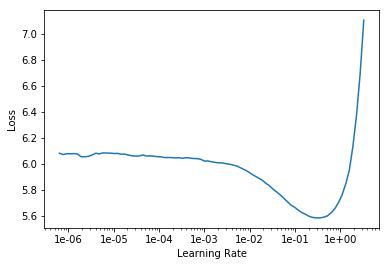

In [9]:
learn.recorder.plot()

In [10]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,3.843988,3.672417,0.375772


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [12]:
learn.save('fit_head1')

In [13]:
learn.load('fit_head1')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList
y: LMLabel (1226243 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: data/quora
x: LMTextList (1226243 items)
[Text xxbos xxmaj how did xxmaj quebec nationalists see their province as a nation in the 1960s ?, Text xxbos xxmaj do you have an adopted dog , how would you encourage people to adopt and not shop ?, Text xxbos xxmaj why does velocity affect time ? xxmaj does velocity affect space geometry ?, Text xxbos xxmaj how did xxmaj otto von xxmaj guericke used the xxmaj magdeburg hemispheres ?, Text xxbos xxmaj can i convert montra xxunk d to a mountain bike by just changing the tyres ?]...
Path: data/quora;

Valid: LabelList
y: LMLabel (136249 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: data/quora
x: LMTextList (136249 items)
[Text xxbos xxmaj what is the benefit of slavery ? xxmaj what can slavery do that no other could ever do ?, Text xxbos xxmaj what malfunction / co

Fine-tuning the model

In [14]:
learn.unfreeze()

In [15]:
learn.lr_find()

epoch     train_loss  valid_loss  accuracy
1         17.492916               
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


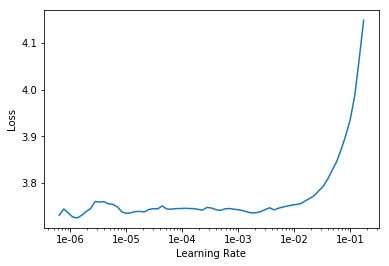

In [19]:
learn.recorder.plot(skip_end=20)

In [20]:
learn.fit_one_cycle(12, 1e-3, moms=(0.8,0.7))

epoch     train_loss  valid_loss  accuracy
1         3.517870    3.465346    0.395781  
2         3.466792    3.402199    0.404362  
3         3.424593    3.374746    0.408326  
4         3.379702    3.344701    0.410925  
5         3.335851    3.324378    0.413368  
6         3.297169    3.307471    0.415560  
7         3.248902    3.293058    0.417247  
8         3.211025    3.280795    0.418403  
9         3.166585    3.273013    0.419793  
10        3.119243    3.267774    0.420451  
11        3.080922    3.266675    0.420681  
12        3.061348    3.267576    0.420548  


In [21]:
learn.save('fine_tuned')

In [12]:
TEXT = 'Happy New Year'
N_WORDS = 15
N_SENTENCES = 2

In [13]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

Happy New Year remind you of you too ? xxbos xxmaj is it possible to drink xxmaj apple
Happy New Year test in xxmaj london ? xxbos xxmaj do girls like to give boys names in


In [14]:
learn.save_encoder('fine_tuned_enc')

# Text Classifier

In [8]:
df = pd.read_csv(path/'train.csv')
df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [9]:
df_test=pd.read_csv(path/'test.csv')
df_test.head()

,qid,question_text
0,00014894849d00ba98a9,My voice range is A2-C5. My chest voice goes u...
1,000156468431f09b3cae,How much does a tutor earn in Bangalore?
2,000227734433360e1aae,What are the best made pocket knives under $20...
3,0005e06fbe3045bd2a92,Why would they add a hypothetical scenario tha...
4,00068a0f7f41f50fc399,What is the dresscode for Techmahindra freshers?


In [10]:
bs=40

In [11]:
data_lm = TextDataBunch.load(path, 'tmp_lm', bs=bs)

In [13]:
data_cl = (TextList.from_csv(path, 'train.csv', vocab=data_lm.vocab)
          .random_split_by_pct(0.1)
          .label_from_df(cols=2)
          .add_test(TextList.from_df(df_test, cols=['question_text']))
          .databunch(bs=40))

In [14]:
gc.collect()

0

In [13]:
data_cl.valid_ds.classes

[0, 1]

In [15]:
data_cl.c

2

In [16]:
len(data_cl.test_ds)

56370

In [17]:
learn = text_classifier_learner(data_cl, drop_mult=0.5)

In [16]:
learn.load_encoder('fine_tuned_enc')

In [17]:
learn.freeze()

In [18]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


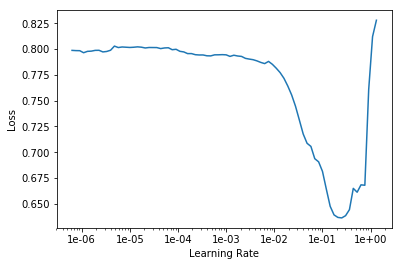

In [19]:
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.222194,0.233682,0.937548


In [21]:
learn.save('first')

In [23]:
%%time
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.247211,0.233700,0.937548


In [24]:
learn.save('second')

In [28]:

learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4), 5e-3), moms=(0.8,0.7))

epoch     train_loss  valid_loss  accuracy
1         0.243962    0.233690    0.937548  


In [29]:
learn.save('third')

In [31]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4), 1e-3), moms=(0.8,0.7))

epoch     train_loss  valid_loss  accuracy
1         0.256087    0.234362    0.937548  
2         0.246028    0.233669    0.937548  


In [32]:
learn.save('final')

## Predict

In [34]:
learn.predict("What is the meaning of love?")

(Category 1, tensor(1), tensor([3.9250e-06, 1.0000e+00]))

## Generate submission

In [ ]:
learn.load('final')

In [19]:
preds, yx = learn.get_preds(ds_type=DatasetType.Test)

In [21]:
preds[:1]

tensor([[0.9457, 0.0543]])

In [25]:
yx[0:5]

tensor([0, 0, 0, 0, 0])

In [23]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [24]:
preds

tensor([[0.9457, 0.0543],
        [0.9433, 0.0567],
        [0.9472, 0.0528],
        ...,
        [0.9377, 0.0623],
        [0.9377, 0.0623],
        [0.9377, 0.0623]])